In [1]:
from ARRG_macro import *

In [2]:
class ObservableDataset(Dataset):
	"""
	Converts observable dataset into PyTorch syntax.
	"""
	def __init__(self, data):
		self.data = data

	def __len__(self):
		return self.data.shape[0]

	def __getitem__(self, idx):
		sample = self.data[idx]
		return sample

In [3]:
def a_b_grid(x_range, y_range, n_points):
    """
    Creates a grid of values within a two-dimensional range and returns it in a flattened tensor.

    Parameters:
    x_range (tuple): A tuple of (min, max) for the x-axis range.
    y_range (tuple): A tuple of (min, max) for the y-axis range.
    steps (int): --- The number of steps/points in each dimension.

    Returns:
    torch.Tensor: A flattened tensor containing all the grid points.
    """
    # Create linearly spaced points for each range
    x_points = torch.linspace(x_range[0], x_range[1], n_points)
    y_points = torch.linspace(y_range[0], y_range[1], n_points)

    # Create a meshgrid from the x and y points
    x_grid, y_grid = torch.meshgrid(x_points, y_points, indexing='ij')

    # Flatten the grid and stack the coordinates
    grid_flattened = torch.stack([x_grid.flatten(), y_grid.flatten()], dim=1)

    return grid_flattened

In [4]:
# Paths to the datasets on perlmutter
exp_hadrons_PATH = '../pgun_qqbar_finalTwo_hadrons_a_0.68_b_0.98_sigma_0.335_N_1e5.npy'
#exp_accept_reject_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_accept_reject_z_a_0.68_b_0.98_sigma_0.335_N_1e6.npy'
sim_hadrons_PATH = '../pgun_qqbar_finalTwo_hadrons_a_0.72_b_0.88_sigma_0.335_N_1e5.npy'
sim_accept_reject_PATH = '../pgun_qqbar_finalTwo_accept_reject_z_a_0.72_b_0.88_sigma_0.335_N_50e3.npy'
sim_fPrel_PATH = '../pgun_qqbar_finalTwo_fPrel_a_0.72_b_0.88_sigma_0.335_N_50e3.npy'

# Load the arrays
exp_hadrons       = np.load(exp_hadrons_PATH, mmap_mode="r")
sim_hadrons       = np.load(sim_hadrons_PATH, mmap_mode="r")
sim_accept_reject = np.load(sim_accept_reject_PATH, mmap_mode = "r")
sim_fPrel         = np.load(sim_fPrel_PATH, mmap_mode = "r")

# Print dataset shapes
print('Experimental observable shape:', exp_hadrons.shape)
print('Simulated observable shape:', sim_hadrons.shape)
print('Simulated z shape:', sim_accept_reject.shape)
print('Simulated fPrel shape:', sim_fPrel.shape)

# Restrict to a subset of the full dataset (for memory)
N_events = int(25000)

# Extract the hadron multiplicity
exp_mult = np.array([len(exp_hadrons[i,:][np.abs(exp_hadrons[i,:,0]) > 0.0]) for i in range(N_events)])
sim_mult = np.array([len(sim_hadrons[i,:][np.abs(sim_hadrons[i,:,0]) > 0.0]) for i in range(N_events)])

# Convert into torch objects
sim_mult          = torch.Tensor(sim_mult[0:N_events].copy())
sim_accept_reject = torch.Tensor(sim_accept_reject[0:N_events].copy())
sim_fPrel            = torch.Tensor(sim_fPrel[0:N_events].copy())
exp_mult          = torch.Tensor(exp_mult[0:N_events].copy())

# Check the accepted z-values, if z == 1 reduce it by epsilon (a very nasty bug to find).
# The a-coefficient when computing the likelihood has a term propotional to log(1-z). If 
# z = 1, this term diverges to -inf and completely destroys the backward pass.
epsilon = 1e-5
sim_accept_reject[sim_accept_reject == 1] = 1 - epsilon

# Print dataset shapes
print('Experimental multiplicity shape:', exp_mult.shape)
print('Simulated multiplicity shape:', sim_mult.shape)
print('Simulated z shape:', sim_accept_reject.shape)
print('Simulated fPrel shape:', sim_fPrel.shape)

# Prepare data for DataLoader
sim_mult          = ObservableDataset(sim_mult)
sim_accept_reject = ObservableDataset(sim_accept_reject)
sim_mT            = ObservableDataset(sim_fPrel)
exp_mult          = ObservableDataset(exp_mult)

Experimental observable shape: (100000, 75, 5)
Simulated observable shape: (100000, 75, 5)
Simulated z shape: (50000, 105, 101)
Simulated fPrel shape: (50000, 105, 100)
Experimental multiplicity shape: torch.Size([25000])
Simulated multiplicity shape: torch.Size([25000])
Simulated z shape: torch.Size([25000, 105, 101])
Simulated fPrel shape: torch.Size([25000, 105, 100])


In [5]:
# Set batch size -- set it eqaul to the number of events, we only want one 'batch'
batch_size = N_events

# Initialize data-loaders
sim_observable_dataloader    = DataLoader(sim_mult,          batch_size = batch_size, shuffle = False)
sim_accept_reject_dataloader = DataLoader(sim_accept_reject, batch_size = batch_size, shuffle = False)
sim_fPrel_dataloader         = DataLoader(sim_fPrel,         batch_size = batch_size, shuffle = False)
exp_observable_dataloader    = DataLoader(exp_mult,          batch_size = batch_size, shuffle = False)

In [6]:
print('Size of sim_observable_dataloader:', len(sim_observable_dataloader.dataset))
print('Size of sim_accept_reject_dataloader:', len(sim_accept_reject_dataloader.dataset))
print('Size of sim_fPrel_dataloader:', len(sim_fPrel_dataloader.dataset))
print('Size of exp_observable_dataloader:', len(exp_observable_dataloader.dataset))

Size of sim_observable_dataloader: 25000
Size of sim_accept_reject_dataloader: 25000
Size of sim_fPrel_dataloader: 25000
Size of exp_observable_dataloader: 25000


In [7]:
# Training hyperparameters
over_sample_factor = 10.0
# The flow map will be dependent on the learning rate
learning_rate = 0.01
fixed_binning = True
# Length of event buffer
dim_multiplicity  = sim_accept_reject_dataloader.dataset.data.shape[1]
dim_accept_reject = sim_accept_reject_dataloader.dataset.data.shape[2]

print('Each event has been zero-padded to a length of', dim_multiplicity)
print('Each emission has been zero-padded to a length of', dim_accept_reject)

# Define base parameters of simulated data (a, b)
params_base = torch.tensor([0.72, 0.88])
# Define a grid of initial parameters
a_range  = (0.6-0.1, 0.80+0.1)#(0.6, 0.80)
b_range  = (0.85-0.1, 1.05+0.1)#(0.85, 1.05)
n_points = 10
a_b_init = a_b_grid(a_range, b_range, n_points)

Each event has been zero-padded to a length of 105
Each emission has been zero-padded to a length of 101


In [8]:
print('Initial a_b grid shape:', a_b_init.shape)

Initial a_b grid shape: torch.Size([100, 2])


In [9]:
# Irrelevant parameters for the flow plot that must be initialized for the ARRG class
epochs = 1
learning_rate = 0.01

# Create an ARRG instance
ARRG = ARRG(epochs = epochs, dim_multiplicity = dim_multiplicity, dim_accept_reject = dim_accept_reject, over_sample_factor = over_sample_factor,
			params_base = params_base, sim_observable_dataloader = sim_observable_dataloader, sim_z_dataloader = sim_accept_reject_dataloader, 
			sim_fPrel_dataloader = sim_fPrel_dataloader, exp_observable_dataloader = exp_observable_dataloader, print_details = False, 
			results_dir = None, params_init = None, fixed_binning = True)

In [10]:
# Set the optimizer
optimizer = torch.optim.Adam(ARRG.weight_nexus.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(macroscopic_trainer.weight_nexus.parameters(), lr=learning_rate)

# Generate gradients!
a_b_gradients, loss_grid = ARRG.ARRG_flow(optimizer, a_b_init)

  1%|▋                                                              | 1/100 [00:10<16:31, 10.01s/it]

----------------------------------------------
Loss: 0.004628491014649876
a: 0.5
Gradient of a: 0.026917066
b: 0.75
Gradient of b: -0.040580325
----------------------------------------------


  2%|█▎                                                             | 2/100 [00:20<16:49, 10.31s/it]

----------------------------------------------
Loss: 0.005376642901635995
a: 0.5
Gradient of a: -0.13380146
b: 0.79444444
Gradient of b: 0.085322276
----------------------------------------------


  3%|█▉                                                             | 3/100 [00:30<16:15, 10.06s/it]

----------------------------------------------
Loss: 0.012922791600634887
a: 0.5
Gradient of a: -0.34342492
b: 0.8388889
Gradient of b: 0.25891078
----------------------------------------------


  4%|██▌                                                            | 4/100 [00:39<15:46,  9.86s/it]

----------------------------------------------
Loss: 0.02854469497185472
a: 0.5
Gradient of a: -0.5800751
b: 0.8833333
Gradient of b: 0.44331753
----------------------------------------------


  5%|███▏                                                           | 5/100 [00:49<15:35,  9.85s/it]

----------------------------------------------
Loss: 0.05208946932868781
a: 0.5
Gradient of a: -0.82688963
b: 0.92777777
Gradient of b: 0.61185133
----------------------------------------------


  6%|███▊                                                           | 6/100 [00:59<15:12,  9.71s/it]

----------------------------------------------
Loss: 0.08245182343176224
a: 0.5
Gradient of a: -1.0721205
b: 0.9722222
Gradient of b: 0.74859834
----------------------------------------------


  7%|████▍                                                          | 7/100 [01:08<15:06,  9.74s/it]

----------------------------------------------
Loss: 0.11814576992998707
a: 0.5
Gradient of a: -1.3099167
b: 1.0166667
Gradient of b: 0.8528916
----------------------------------------------


  8%|█████                                                          | 8/100 [01:18<15:01,  9.80s/it]

----------------------------------------------
Loss: 0.1579130428257848
a: 0.5
Gradient of a: -1.5386771
b: 1.0611111
Gradient of b: 0.9333722
----------------------------------------------


  9%|█████▋                                                         | 9/100 [01:28<14:50,  9.79s/it]

----------------------------------------------
Loss: 0.20088649005079967
a: 0.5
Gradient of a: -1.760189
b: 1.1055555
Gradient of b: 0.998836
----------------------------------------------


  9%|█████▋                                                         | 9/100 [01:38<16:36, 10.95s/it]


KeyboardInterrupt: 

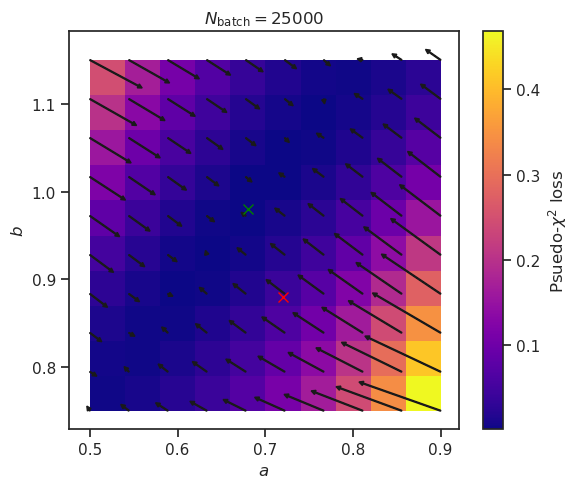

In [ ]:
# Clone a_b_init into numpy array
a_b = a_b_init.detach().numpy()

import matplotlib.colors as mcolors

# Calculate the magnitude of each vector in a_b_gradients
magnitudes = np.linalg.norm(a_b_gradients, axis=1)

fig, ax = plt.subplots(1,1,figsize=(6,5))

# Set the background color based on the magnitude
# Normalize the magnitude to use it with the colormap
norm = mcolors.Normalize(vmin=np.min(magnitudes), vmax=np.max(magnitudes))
cmap = plt.cm.plasma  # Choose a colormap

# Assuming magnitudes can be reshaped into a grid directly for simplicity
# In a real scenario, you might need to interpolate these values onto a grid
grid_shape = (int(np.sqrt(len(magnitudes))), int(np.sqrt(len(magnitudes))))
magnitudes_grid = magnitudes.reshape(grid_shape).T

# Create a heatmap of the gradient magnitudes
#heatmap = ax.imshow(magnitudes_grid, cmap=cmap, norm=norm, origin='lower', extent=(np.min(a_b[:, 0]), np.max(a_b[:, 0]), np.min(a_b[:, 1]), np.max(a_b[:, 1])))
heatmap = ax.imshow((loss_grid / N_events).reshape(grid_shape).T, cmap=cmap, origin='lower', extent=(np.min(a_b[:, 0]), np.max(a_b[:, 0]), np.min(a_b[:, 1]), np.max(a_b[:, 1])))

# Add a colorbar to show the magnitude scale
#fig.colorbar(heatmap, ax=ax, label=r'$|\vec{\nabla}_\theta \mathcal{L}|$')
fig.colorbar(heatmap, ax=ax, label=r'Psuedo-$\chi^2$ loss')

# Plot arrows for each point and direction
for point, gradient in zip(a_b, a_b_gradients):
    ax.arrow(point[0], point[1], -gradient[0]/9e5, -gradient[1]/9e5, head_width=0.005, head_length=0.005, fc='k', ec='k')

a_b_target = np.array([0.68, 0.98]) # Monash
ax.plot(a_b_target[0], a_b_target[1], 'x', color='green', label = 'Target', ms = 7, linewidth=10)#label = r'$\mathrm{Target}$')
ax.plot(ARRG.params_base[0].clone().detach().numpy(), ARRG.params_base[1].clone().detach().numpy(), 'x', color = 'red', label = 'Base', ms = 7, linewidth=10)#label = r'$\mathrm{Base}$'

ax.set_title(rf'$N_{{\mathrm{{batch}}}} = {N_events}$')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')

fig.tight_layout()
fig.savefig('ARRG_flow_psuedo_chi2_loss_fixed_bin_Nbatch_25e3.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
fig.savefig('ARRG_flow_psuedo_chi2_loss_fixed_bin_Nbatch_25e3.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [12]:
# Save the (a,b) values, their gradients, and the loss grid
np.save('flow_data/flow_data_finalTwo_pseudo_chi2_a_b_Nbatch_25e3_fixed.npy', a_b)
np.save('flow_data/flow_data_finalTwo_pseudo_chi2_a_b_gradients_Nbatch_25e3_fixed.npy', a_b_gradients)
np.save('flow_data/flow_data_finalTwo_pseudo_chi2_losses_Nbatch_25e3_fixed.npy', loss_grid)

In [13]:
# Loading previous flow map
a_b           = np.load('flow_data/flow_data_finalTwo_pseudo_chi2_a_b_Nbatch_25e3_fixed.npy')
a_b_gradients = np.load('flow_data/flow_data_finalTwo_pseudo_chi2_a_b_gradients_Nbatch_25e3_fixed.npy')
loss_grid     = np.load('flow_data/flow_data_finalTwo_pseudo_chi2_losses_Nbatch_25e3_fixed.npy')

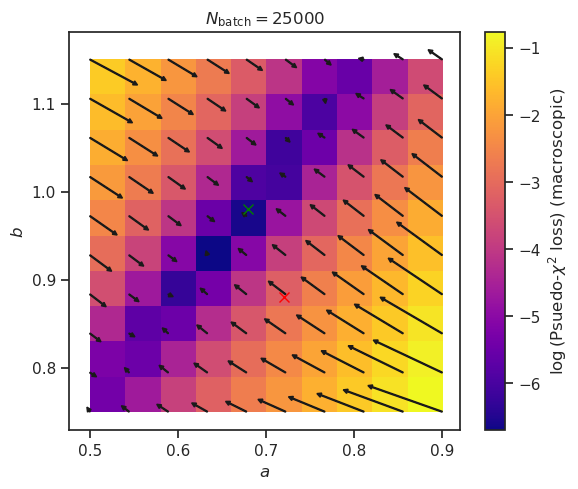

In [16]:
# Clone a_b_init into numpy array
a_b = a_b_init.detach().numpy()

import matplotlib.colors as mcolors

# Calculate the magnitude of each vector in a_b_gradients
magnitudes = np.linalg.norm(a_b_gradients, axis=1)

fig, ax = plt.subplots(1,1,figsize=(6,5))

# Set the background color based on the magnitude
# Normalize the magnitude to use it with the colormap
norm = mcolors.Normalize(vmin=np.min(magnitudes), vmax=np.max(magnitudes))
cmap = plt.cm.plasma  # Choose a colormap

# Assuming magnitudes can be reshaped into a grid directly for simplicity
# In a real scenario, you might need to interpolate these values onto a grid
grid_shape = (int(np.sqrt(len(magnitudes))), int(np.sqrt(len(magnitudes))))
magnitudes_grid = magnitudes.reshape(grid_shape).T

# Create a heatmap of the gradient magnitudes
#heatmap = ax.imshow(magnitudes_grid, cmap=cmap, norm=norm, origin='lower', extent=(np.min(a_b[:, 0]), np.max(a_b[:, 0]), np.min(a_b[:, 1]), np.max(a_b[:, 1])))
heatmap = ax.imshow((np.log((loss_grid / N_events))).reshape(grid_shape).T, cmap=cmap, origin='lower', extent=(np.min(a_b[:, 0]), np.max(a_b[:, 0]), np.min(a_b[:, 1]), np.max(a_b[:, 1])))

# Add a colorbar to show the magnitude scale
#fig.colorbar(heatmap, ax=ax, label=r'$|\vec{\nabla}_\theta \mathcal{L}|$')
fig.colorbar(heatmap, ax=ax, label=r'$\log$(Psuedo-$\chi^2$ loss) (macroscopic)')

# Plot arrows for each point and direction
for point, gradient in zip(a_b, a_b_gradients):
    ax.arrow(point[0], point[1], -gradient[0]/10e5, -gradient[1]/10e5, head_width=0.005, head_length=0.005, fc='k', ec='k')

a_b_target = np.array([0.68, 0.98]) # Monash
ax.plot(a_b_target[0], a_b_target[1], 'x', color='green', label = 'Target', ms = 7, linewidth=10)#label = r'$\mathrm{Target}$')
ax.plot(ARRG.params_base[0].clone().detach().numpy(), ARRG.params_base[1].clone().detach().numpy(), 'x', color = 'red', label = 'Base', ms = 7, linewidth=10)#label = r'$\mathrm{Base}$'

ax.set_title(rf'$N_{{\mathrm{{batch}}}} = {N_events}$')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')

fig.tight_layout()
fig.savefig('ARRG_flow_psuedo_chi2_log_loss_fixed_bin_Nbatch_25e3.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
fig.savefig('ARRG_flow_psuedo_chi2_log_loss_fixed_bin_Nbatch_25e3.png', dpi=300, bbox_inches='tight', pad_inches=0.1)